In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout, SimpleRNN, Flatten
from tensorflow.keras.regularizers import l2

In [29]:
## Import up sound alert dependencies
from IPython.display import Audio, display

def allDone():
  display(Audio(url='https://sound.peal.io/ps/audios/000/000/537/original/woo_vu_luvub_dub_dub.wav', autoplay=True))
## Insert whatever audio file you want above

In [3]:
data = pd.read_csv('../raw_data/marged_df_update.csv')
data

,text,is_fake
0,Donald Trump just couldn t wish all Americans ...,1
1,House Intelligence Committee Chairman Devin Nu...,1
2,"On Friday, it was revealed that former Milwauk...",1
3,"On Christmas day, Donald Trump announced that ...",1
4,Pope Francis used his annual Christmas Day mes...,1
...,...,...
37312,NATO allies on Tuesday welcomed President Dona...,0
37313,"LexisNexis, a provider of legal, regulatory an...",0
37314,In the shadow of disused Soviet-era factories ...,0
37315,Vatican Secretary of State Cardinal Pietro Par...,0


In [4]:
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

def cleaning(sentence):
    
    # Basic cleaning
    sentence = sentence.strip() ## remove whitespaces
    sentence = sentence.lower() ## lowercase 
    sentence = ''.join(char for char in sentence if not char.isdigit()) ## remove numbers
    
    # Advanced cleaning
    for punctuation in string.punctuation:
        sentence = sentence.replace(punctuation, '') ## remove punctuation
    
    tokenized_sentence = word_tokenize(sentence) ## tokenize 
    stop_words = set(stopwords.words('english')) ## define stopwords
    
    tokenized_sentence_cleaned = [ ## remove stopwords
        w for w in tokenized_sentence if not w in stop_words
    ]

    lemmatized = [
        WordNetLemmatizer().lemmatize(word, pos = "v") 
        for word in tokenized_sentence_cleaned
    ]
    
    cleaned_sentence = ' '.join(word for word in lemmatized)
    
    return cleaned_sentence

In [5]:
%%time

data['text_clean'] = data['text'].apply(cleaning)
data

CPU times: user 1min 53s, sys: 2.54 s, total: 1min 55s
Wall time: 1min 56s


,text,is_fake,text_clean
0,Donald Trump just couldn t wish all Americans ...,1,donald trump wish americans happy new year lea...
1,House Intelligence Committee Chairman Devin Nu...,1,house intelligence committee chairman devin nu...
2,"On Friday, it was revealed that former Milwauk...",1,friday reveal former milwaukee sheriff david c...
3,"On Christmas day, Donald Trump announced that ...",1,christmas day donald trump announce would back...
4,Pope Francis used his annual Christmas Day mes...,1,pope francis use annual christmas day message ...
...,...,...,...
37312,NATO allies on Tuesday welcomed President Dona...,0,nato ally tuesday welcome president donald tru...
37313,"LexisNexis, a provider of legal, regulatory an...",0,lexisnexis provider legal regulatory business ...
37314,In the shadow of disused Soviet-era factories ...,0,shadow disused sovietera factories minsk stree...
37315,Vatican Secretary of State Cardinal Pietro Par...,0,vatican secretary state cardinal pietro paroli...


In [6]:
# SAMPLE DATA (10%)

sampled_data = data.sample(frac=0.1, random_state=42)
sampled_data

,text,is_fake,text_clean
17151,President Donald Trump and the U.S. House of R...,0,president donald trump us house representative...
14946,Leave your cowboy boots and Hawaiian leis at h...,1,leave cowboy boot hawaiian leis home halloween...
7916,Watching a good old-fashioned troll perpetrate...,1,watch good oldfashioned troll perpetrate uninf...
24387,Mexican President Enrique Pena Nieto on Wednes...,0,mexican president enrique pena nieto wednesday...
9128,"On December 5, 2017, Circa s Sara Carter warne...",1,december circa sara carter warn would major sh...
...,...,...,...
30212,Turkey has not been given crucial data to help...,0,turkey give crucial data help identify islamic...
37053,Australia s military watchdog has issued a pub...,0,australia military watchdog issue public plea ...
1305,Most of us tend to be quite selective about wh...,1,us tend quite selective give phone number woul...
4082,While the controversy over Trump s personal ta...,1,controversy trump personal tax return continue...


In [7]:
X = sampled_data.text_clean
y = sampled_data.is_fake

In [8]:
# Perform a 70:30 split for the initial training set and temporary set
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)

# Further split the temporary set into validation (50%) and test (50%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [9]:
%%time
# max_words = 10000  
# max_sequence_length = 500  

# Initialize the tokenizer and fit it on the training data
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index

CPU times: user 855 ms, sys: 14 ms, total: 869 ms
Wall time: 870 ms


In [10]:
len(word_index)

37425

In [11]:
# Convert text data to sequences of integers
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_val_sequences = tokenizer.texts_to_sequences(X_val)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

In [12]:
sequences = tokenizer.texts_to_sequences(data.text_clean)

lengths_of_texts =  [len(text) for text in sequences]

## For length to pad till, we use the average length of all texts 
avg_length_text = int(np.mean(lengths_of_texts))

X_train_pad = pad_sequences(X_train_sequences, maxlen=avg_length_text, padding='post', truncating='post')
X_val_pad = pad_sequences(X_val_sequences, maxlen=avg_length_text, padding='pre')
X_test_pad = pad_sequences(X_test_sequences, maxlen=avg_length_text, padding='post', truncating='post')

---

## SimpleRNN Model

In [34]:
%%time
from keras.callbacks import EarlyStopping

model_rnn = Sequential([
    Embedding(input_dim = len(word_index), output_dim = 8, 
             input_length=avg_length_text), ## recall that we set the post-padding length to be this value
    SimpleRNN(16), ## THIS IS THE RECURRENT LAYER 
    Dropout(0.2),
    Dense(8, activation='relu'),
    Dropout(0.2), 
    Dense(1, activation= 'sigmoid') ## final layer for prediction, hence only one node
])

## compile -- add optim, add loss, add metrics 
model_rnn.compile(optimizer = 'adam', loss = ['binary_crossentropy'], metrics = ['accuracy'])

early_stopping = EarlyStopping(patience=10, restore_best_weights=True)

history_rnn = model_rnn.fit(X_train_pad, y_train, epochs=1000, batch_size=16, validation_data=(X_val_pad, y_val), callbacks=[early_stopping])

allDone()

Epoch 1/1000
164/164 [==============================] - 8s 42ms/step - loss: 0.6895 - accuracy: 0.5479 - val_loss: 0.6814 - val_accuracy: 0.5768
Epoch 2/1000
164/164 [==============================] - 6s 39ms/step - loss: 0.6724 - accuracy: 0.5823 - val_loss: 0.6811 - val_accuracy: 0.5821
Epoch 3/1000
164/164 [==============================] - 6s 39ms/step - loss: 0.6289 - accuracy: 0.6432 - val_loss: 0.6696 - val_accuracy: 0.6000
Epoch 4/1000
164/164 [==============================] - 6s 39ms/step - loss: 0.5478 - accuracy: 0.7182 - val_loss: 0.6975 - val_accuracy: 0.5857
Epoch 5/1000
164/164 [==============================] - 6s 39ms/step - loss: 0.4904 - accuracy: 0.7676 - val_loss: 0.6859 - val_accuracy: 0.6161
Epoch 6/1000
164/164 [==============================] - 6s 39ms/step - loss: 0.4199 - accuracy: 0.8178 - val_loss: 0.8427 - val_accuracy: 0.5589
Epoch 7/1000
164/164 [==============================] - 7s 40ms/step - loss: 0.4270 - accuracy: 0.7802 - val_loss: 0.8700 - val_ac

CPU times: user 3min 7s, sys: 48.8 s, total: 3min 56s
Wall time: 1min 27s


In [35]:
# Evaluate the model on the test set
loss, accuracy = model_rnn.evaluate(X_test_pad, y_test)

18/18 [==============================] - 0s 8ms/step - loss: 0.6942 - accuracy: 0.5661


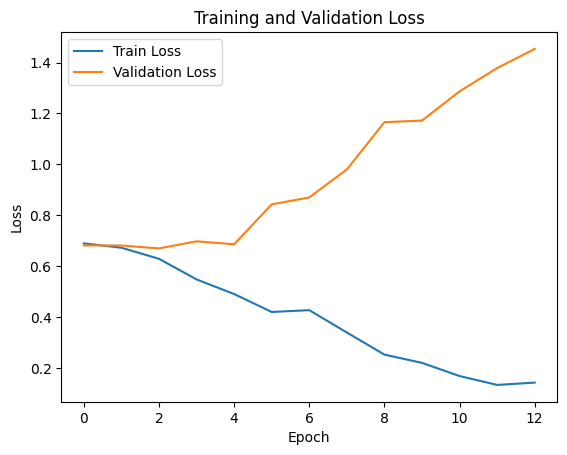

In [36]:
# Plot the training and validation loss
plt.plot(history_rnn.history['loss'], label='Train Loss')
plt.plot(history_rnn.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

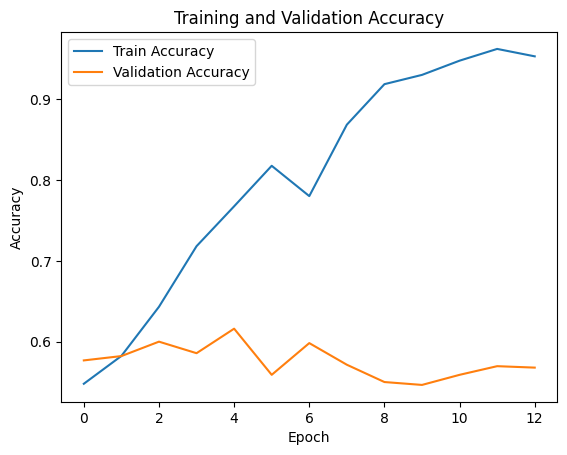

In [37]:
plt.plot(history_rnn.history['accuracy'], label='Train Accuracy')
plt.plot(history_rnn.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
y_pred = model_rnn.predict(X_test_pad)

In [ ]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
import tensorflow as tf

predicted = tf.squeeze(y_pred)
predicted = np.array([1 if x >= 0.5 else 0 for x in predicted])
actual = np.array(y_test)
conf_mat = confusion_matrix(actual, predicted)
displ = ConfusionMatrixDisplay(confusion_matrix=conf_mat)
displ.plot()

---

## Basic NN Model

In [ ]:
# model_3 = Sequential([
#     Embedding(input_dim=len(word_index), output_dim=8, input_length=avg_length_text),
#     Flatten(),
#     Dense(8, activation='relu', kernel_regularizer=l2(0.01)),  # L2 regularization
#     Dropout(0.5),  # Adding dropout
#     Dense(1, activation='sigmoid')
# ])

# model_3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# ## Decrease patience, allow restore to best weights during patience
# early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# history_3 = model_3.fit(X_train_pad, y_train, epochs=50, batch_size=200, validation_data=(X_val_pad, y_test), callbacks=[early_stopping])

In [ ]:
# final_train_loss_3 = history_3.history['loss'][-1]
# final_train_accuracy_3 = history_3.history['accuracy'][-1]

# final_val_loss_3 = history_3.history['val_loss'][-1]
# final_val_accuracy_3 = history_3.history['val_accuracy'][-1]

# print("Final Training Loss:", final_train_loss_3)
# print("Final Training Accuracy:", final_train_accuracy_3)
# print("Final Validation Loss:", final_val_loss_3)
# print("Final Validation Accuracy:", final_val_accuracy_3)


In [ ]:
# # Plot the training and validation loss
# plt.plot(history_3.history['loss'], label='Train Loss')
# plt.plot(history_3.history['val_loss'], label='Validation Loss')
# plt.title('Training and Validation Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()

---

## New Texts on Both Models

In [ ]:
bbc_snippet = """The UK faces another five years of high interest rates to stem rising prices, an influential global group has warned.
The International Monetary Fund expects the UK to have the highest inflation and slowest growth next year of any G7 economy including the US, France, Germany, Canada, Italy and Japan.
However, the Treasury said recent revisions to UK growth had not been factored in to the IMF's report.
The outlook was drawn up before this weekend's developments in Israel.
Forecasts are never perfect given the many factors that affect economic growth - from geopolitics to the weather. But such reports can point in the right direction, especially where they align with other forecasts.
The IMF, an international organisation with 190 member countries, has said the forecasts it makes for growth the following year in most advanced economies have, more often than not, been within about 1.5 percentage points of what actually happens.
In July last year, it forecast that the UK economy would grow by 3.2% in 2022. It revised that upwards to 4.1% at the start of this year.
But official UK figures released last month estimated that the country's economy actually expanded by 4.3% in 2022.
According to the IMF's latest forecast which it produces every six months, it expects the UK to grow more quickly than Germany in 2023, keeping the UK out of bottom place for growth among the G7.
But it downgraded the UK's prospects for growth next year, estimating the economy will grow by 0.6%, making it the slowest growing developed country in 2024 - widely predicted to be a general election year."""


In [ ]:
theonion_snippet = """Claiming they had already made up their minds, area man Karl Wooley told reporters Tuesday 
that he felt like the bystanders who were urging him to put his gun down were arguing in bad faith. “If I’m being 
honest, it sort of feels like these onlookers are only thinking of themselves when they tell me to drop my pistol,” said Wooley, who observed that no one had even asked him to explain his reasoning for shouting at the top of his lungs and waving around a semiautomatic firearm. “Truth be told, they poisoned the well the second they tried to tackle me and forcibly rip the gun from my hands. But the worst part is how condescending they are—saying things like, ‘Hey, buddy, you don’t really want to do this.’ Maybe if they’d bothered to find out where I’m coming from and what my thoughts on the matter are, they’d know this is exactly what I want to be doing.” At press time, Wooley was reportedly shaking his head at how disrespectful his victims had become when they began resorting to ad hominem attacks like “You’re a monster” as he shot them to death."""

In [ ]:
import spacy
from spacy.lang.en import English
from nltk.corpus import stopwords
import nltk
import time

## download the dictionary for stopwords
nltk.download('stopwords')

## get the set of stopwords 
stop_words_set = set(stopwords.words('english'))

## Load English tokenizer from spacy
nlp = English()
spacy_tokenizer = nlp.tokenizer ## make instance 

## Create function to clean text -- lowercase, remove non alphanumeric, remove stop words
def optimized_preprocess(texts): ## Takes in a list of texts, i.e. the entire corpus
    result = []
    
    # Tokenize using spaCy's tokenizer
    for text in texts:
        tokens = [token.text.lower() for token in spacy_tokenizer(text) if token.text.isalpha() and token.text.lower() not in stop_words_set]
        result.append(" ".join(tokens))
    
    return result

In [ ]:
bbc_cleaned = optimized_preprocess([bbc_snippet])
theonion_cleaned = optimized_preprocess([theonion_snippet])


In [ ]:
bbc_seq = tokenizer.texts_to_sequences(bbc_cleaned)
theonion_seq = tokenizer.texts_to_sequences(theonion_cleaned)


In [ ]:
bbc_pad = pad_sequences(bbc_seq, maxlen= avg_length_text, padding = 'post', truncating = 'post')
theonion_pad = pad_sequences(theonion_seq, maxlen=  avg_length_text, padding = 'post', truncating = 'post')

In [ ]:
# print(model_3.predict(bbc_pad))
# print(model_3.predict(theonion_pad))

# print('\n\n ======================= \n\n')

In [ ]:
print(model_rnn.predict(bbc_pad))
print(model_rnn.predict(theonion_pad))

In [ ]:
model_rnn.predict(bbc_pad)

In [ ]:
model_rnn.predict(theonion_pad)